# Описание проекта

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

# Условия задачи

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

1 единица продукта - 1000 баррелей

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [35]:
def data_frame_check(a1,a2,a3):
    list_df = [a1,a2,a3]
    count=0
    for i in list_df:
        count += 1
        print(f'\033[1mПервые пять строк датафрейма региона {count}\033[0m')
        display(i)
        print()
        print(f'\033[1mПропуски датафрейма региона {count}\033[0m')
        print(i.isna().sum())
        print()
        print(f'\033[1mДубли датафрейма региона {count}\033[0m')
        print(i.duplicated().sum())
        print()
        print(f'\033[1mОписание величин региона {count}\033[0m')
        print(i.describe())
        print(f'\033[1mВсего строк в датафрейме региона {count}: {len(i)}, а у никальных id: {i.id.nunique()}\033[0m')
        print("\n" + "=" * 50 + "\n")
        
        

In [186]:
def ridge_learning(X_train,y_train):
    alpha_coef = [0.001,0.01,0.1,0.5,1,1.5,2,4,5,7,10]
    res_list = []
    i_list = []
    df_res=pd.DataFrame()
    for i in tqdm(alpha_coef):
        model = Ridge(alpha=i, random_state = RANDOM_STATE)
        res_avg = np.mean(cross_val_score(model, X_train, y_train, cv=5))

        res_list.append(res_avg)
        i_list.append(i)

    df_res = pd.DataFrame({'r2':res_list,'alpha':i_list})

    return df_res

def linear_learning(X_train,y_train):
    #alpha_coef = [0.001,0.01,0.1,0.5,1,1.5,2,4,5,7,10]
    res_list = []
    i_list = []
    df_res=pd.DataFrame()
    #for i in tqdm(alpha_coef):
    model = LinearRegression()
    res_avg = np.mean(cross_val_score(model, X_train, y_train, cv=5))

    res_list.append(res_avg)
    i_list.append('lin_reg')

    df_res = pd.DataFrame({'r2':res_list,'model':i_list})

    return df_res

def lasso_learning(X_train,y_train):
    alpha_coef = [0.001,0.01,0.1,0.5,1,1.5,2,4,5,7,10]
    res_list = []
    i_list = []
    df_res=pd.DataFrame()
    for i in tqdm(alpha_coef):
        model = Lasso(alpha=i, random_state = RANDOM_STATE)
        res_avg = np.mean(cross_val_score(model, X_train, y_train, cv=5))

        res_list.append(res_avg)
        i_list.append(i)

    df_res = pd.DataFrame({'r2':res_list,'alpha':i_list})

    return df_res

# Импортируем нужные библиотеки

In [192]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import warnings
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


RANDOM_STATE = 12345
warnings.filterwarnings("ignore")


# Загрузка и изучение данных

In [37]:
borehole_1 = pd.read_csv('geo_data_0.csv')
borehole_2 = pd.read_csv('geo_data_1.csv')
borehole_3 = pd.read_csv('geo_data_2.csv')

## Общие сведения о датафреймах

In [38]:
data_frame_check(borehole_1,borehole_2,borehole_3)

Первые пять строк датафрейма региона 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764



Пропуски датафрейма региона 1
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубли датафрейма региона 1
0

Описание величин региона 1
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
Всего строк в датафрейме региона 1: 100000, а у никальных id: 99990


Первые пять строк датафрейма региона 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364



Пропуски датафрейма региона 2
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубли датафрейма региона 2
0

Описание величин региона 2
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408
Всего строк в датафрейме региона 2: 100000, а у никальных id: 99996


Первые пять строк датафрейма региона 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253



Пропуски датафрейма региона 3
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Дубли датафрейма региона 3
0

Описание величин региона 3
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838
Всего строк в датафрейме региона 3: 100000, а у никальных id: 99996




- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [39]:
borehole_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [41]:
borehole_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [42]:
borehole_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Посмотрим на дубли по айди скважины

In [51]:
borehole_1.loc[borehole_1.id.isin(borehole_1.loc[borehole_1.id.duplicated()].id.unique())].sort_values(by = 'id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Не исключаем, что одна скважина давала данные в разное время, поэтому обьем получался другой. Т.к. мы не осведомлены в значениях признаков и не можем задетектить правильный или не правильный сбор данных, строки с дублями id оставляем

# Проверка корреляции признаков

<Axes: >

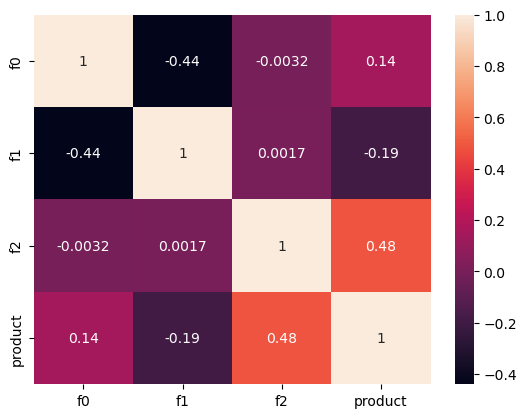

In [65]:
sns.heatmap(borehole_1.drop(columns = 'id').corr(), annot = True)

<Axes: >

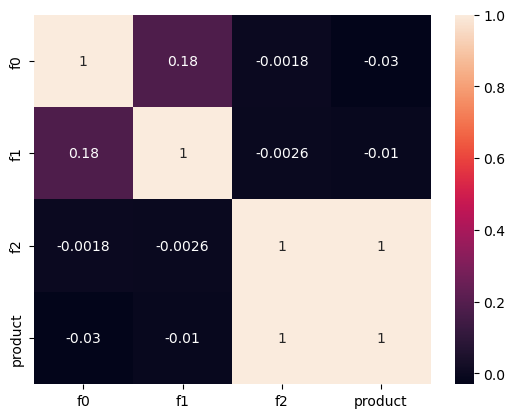

In [66]:
sns.heatmap(borehole_2.drop(columns = 'id').corr(), annot = True)

<Axes: >

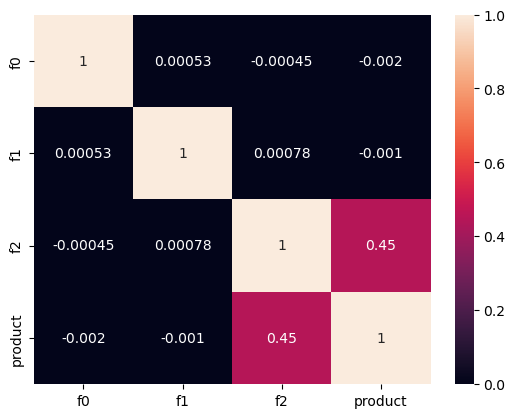

In [67]:
sns.heatmap(borehole_3.drop(columns = 'id').corr(), annot = True)

Между признаками отсутствует сильная корреляция. Плюс мы видим довольно разные зависимости признаков от целевого признака, что свидетельствует о том, что для каждого региона понадобиться отдельная модель

# Посмотрим как таргет зависит от каждого признака(чтобы решить нужно ли использовать лассо или ридж)

## Регион 1

In [124]:
def my_plotter(ax, data1, data2, param_dict):
    """
    A helper function to make a graph.
    """
    out = ax.scatter(data1, data2, **param_dict, label = data1.name)
    ax.legend()
    return out

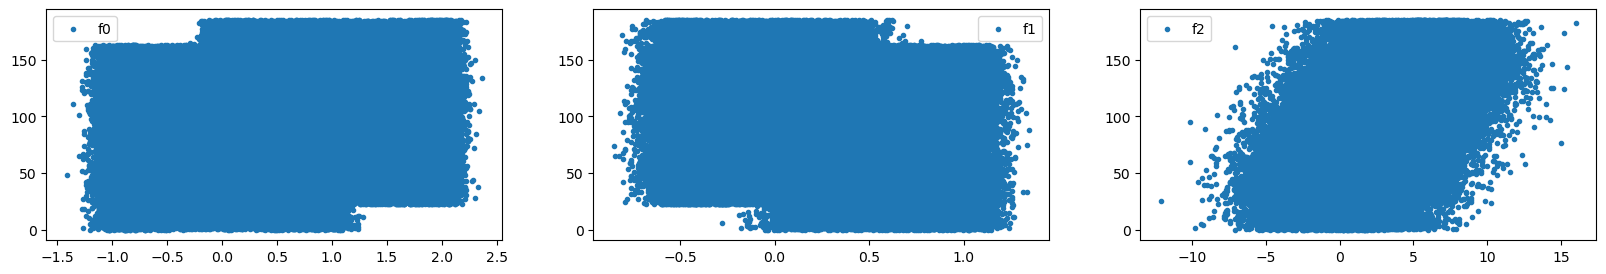

In [130]:
data1, data2, data3, data4 = borehole_1['f0'],borehole_1['f1'],borehole_1['f2'],borehole_1['product']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 3))
my_plotter(ax1, data1, data4, {'marker': '.'})
my_plotter(ax2, data2, data4, {'marker': '.'})
my_plotter(ax3, data3, data4, {'marker': '.'})

## Регион 2

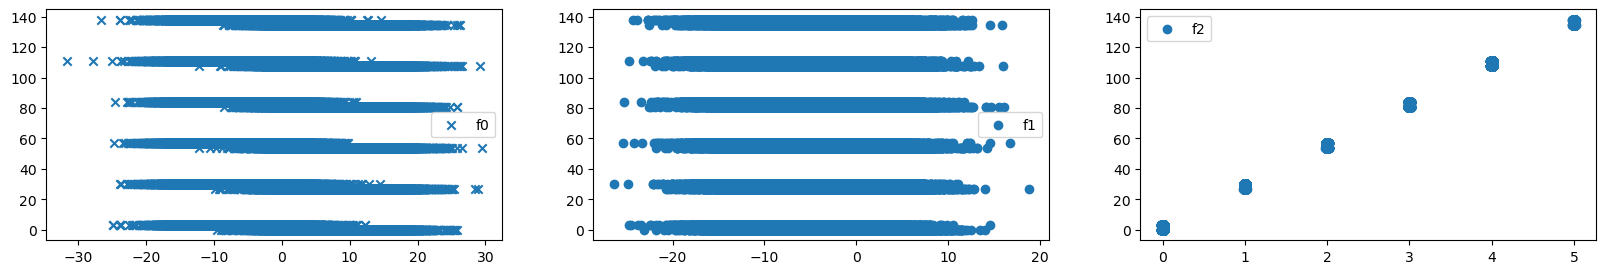

In [126]:
data1, data2, data3, data4 = borehole_2['f0'],borehole_2['f1'],borehole_2['f2'],borehole_2['product']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 3))
my_plotter(ax1, data1, data4, {'marker': 'x'})
my_plotter(ax2, data2, data4, {'marker': 'o'})
my_plotter(ax3, data3, data4, {'marker': 'o'})

## Регион 3

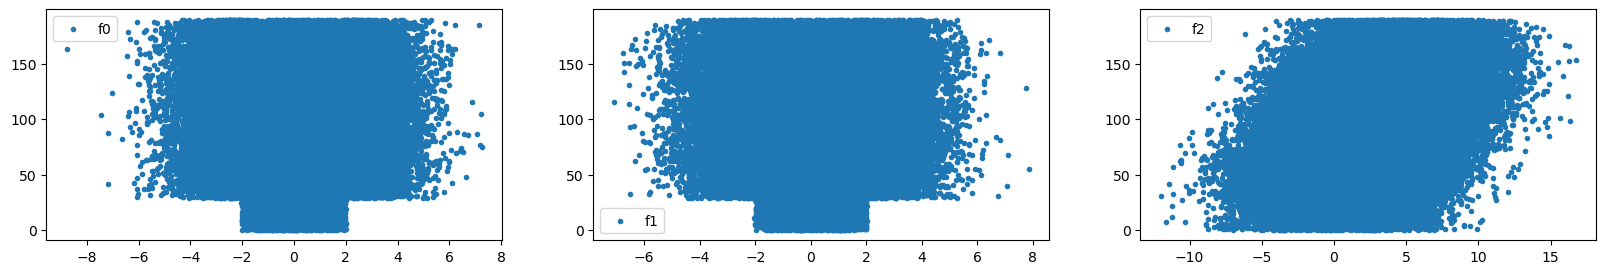

In [129]:
data1, data2, data3, data4 = borehole_3['f0'],borehole_3['f1'],borehole_3['f2'],borehole_3['product']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 3))
my_plotter(ax1, data1, data4, {'marker': '.'})
my_plotter(ax2, data2, data4, {'marker': '.'})
my_plotter(ax3, data3, data4, {'marker': '.'})

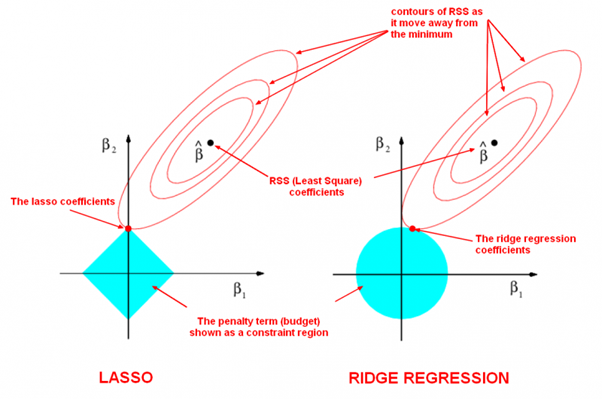

Будем использовать LASSO т.к. есть подозрения, что искать связь со всеми признаками будет лишним.

# Обучение моделей 

## Регион 1

In [348]:
borehole_1

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [349]:
X1 = borehole_1.drop(columns=['id','product'])

In [350]:
y1 = borehole_1['product']

In [351]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X1,y1, test_size = 0.25, random_state = RANDOM_STATE)

In [352]:
print(X_1_train.shape)
print(X_1_test.shape)

(75000, 3)
(25000, 3)


In [353]:
df_res_1 = lasso_learning(X_1_train,y_1_train)

  0%|          | 0/11 [00:00<?, ?it/s]

In [354]:
df_res_1.sort_values('r2', ascending = False)

,r2,alpha
0,0.274087,0.001
1,0.274086,0.010
2,0.274066,0.100
3,0.273565,0.500
4,0.271991,1.000
5,0.269367,1.500
6,0.265691,2.000
7,0.241862,4.000
8,0.235384,5.000
9,0.231031,7.000


In [355]:
df_res_1_ridge = ridge_learning(X_1_train,y_1_train)

  0%|          | 0/11 [00:00<?, ?it/s]

In [356]:
df_res_1_ridge.sort_values('r2', ascending = False)

,r2,alpha
10,0.274087,10.000
9,0.274087,7.000
8,0.274087,5.000
7,0.274087,4.000
6,0.274087,2.000
5,0.274087,1.500
4,0.274087,1.000
3,0.274087,0.500
2,0.274087,0.100
1,0.274087,0.010


In [357]:
df_res_1_linear = linear_learning(X_1_train,y_1_train)

In [358]:
df_res_1_linear

,r2,model
0,0.274087,lin_reg


Выберем обычную линейную регрессию, там качевство модели аналогичное.

In [359]:
model1= LinearRegression()

model1.fit(X_1_train,y_1_train)

LinearRegression()

### Тестируем на валидационной выборке

In [ ]:
y_1_test.reset_index(drop=True)

0         10.038645
1        114.551489
2        132.603635
3        169.072125
4        122.325180
            ...    
24995    170.116726
24996     93.632175
24997    127.352259
24998     99.782700
24999    177.821022
Name: product, Length: 25000, dtype: float64

In [ ]:
pd.Series(predictions_reg1)

0         95.894952
1         77.572583
2         77.892640
3         90.175134
4         70.510088
            ...    
24995    103.037104
24996     85.403255
24997     61.509833
24998    118.180397
24999    118.169392
Length: 25000, dtype: float64

In [368]:
predictions_reg1 = pd.Series(model1.predict(X_1_test))
target_reg1 = y_1_test.reset_index(drop=True)


print(f'''
R2={r2_score(y_1_test,predictions_reg1)}
RMSE={(mean_squared_error(y_1_test,predictions_reg1))**0.5}
''')


R2=0.27994321524487786
RMSE=37.5794217150813



## Регион 2

In [197]:
X2 = borehole_2.drop(columns=['id','product'])
y2 =  borehole_2['product']

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X2,y2, test_size = 0.25, random_state = RANDOM_STATE)

print(X_2_train.shape)
print(X_2_test.shape)

(75000, 3)
(25000, 3)


In [199]:
df_res_2 = lasso_learning(X_2_train,y_2_train)

print(f'''Lasso {df_res_2.sort_values(by = 'r2', ascending = False).head()}''')

print()

df_res_2_ridge = ridge_learning(X_2_train,y_2_train)

print(f'''Ridge {df_res_2_ridge.sort_values(by = 'r2', ascending = False).head()}''')

print()

df_res_2_linear = linear_learning(X_2_train,y_2_train)

print(f'''Linear {df_res_2_linear.head()}''')


  0%|          | 0/11 [00:00<?, ?it/s]

Lasso          r2  alpha
0  0.999625  0.001
1  0.999625  0.010
2  0.999623  0.100
3  0.999579  0.500
4  0.999450  1.000



  0%|          | 0/11 [00:00<?, ?it/s]

Ridge          r2  alpha
3  0.999625  0.500
2  0.999625  0.100
1  0.999625  0.010
0  0.999625  0.001
4  0.999625  1.000

Linear          r2    model
0  0.999625  lin_reg


Выберем для обучения так же обычную линейную регрессию 

In [200]:
model2= LinearRegression()

model2.fit(X_2_train,y_2_train)

LinearRegression()

### Тестируем на валидационной выборке 

In [369]:
predictions_reg2 = pd.Series(model2.predict(X_2_test))
target_reg2 = y_2_test.reset_index(drop=True)


print(f'''
R2={r2_score(y_2_test,predictions_reg2)}
RMSE={(mean_squared_error(y_2_test,predictions_reg2))**0.5}
''')


R2=0.9996233978805127
RMSE=0.8930992867756165



Очень хороший результат, который говорит о четкой линейной зависимости

## Регион 3

In [202]:
X3 = borehole_3.drop(columns=['id','product'])
y3 =  borehole_3['product']

X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X3,y3, test_size = 0.25, random_state = RANDOM_STATE)

print(X_3_train.shape)
print(X_3_test.shape)

(75000, 3)
(25000, 3)


In [203]:
df_res_3 = lasso_learning(X_3_train,y_3_train)

print(f'''Lasso {df_res_3.sort_values(by = 'r2', ascending = False).head()}''')

print()

df_res_3_ridge = ridge_learning(X_3_train,y_3_train)

print(f'''Ridge {df_res_3_ridge.sort_values(by = 'r2', ascending = False).head()}''')

print()

df_res_3_linear = linear_learning(X_3_train,y_3_train)

print(f'''Linear {df_res_3_linear.head()}''')


  0%|          | 0/11 [00:00<?, ?it/s]

Lasso          r2  alpha
3  0.196494  0.500
2  0.196486  0.100
0  0.196482  0.001
1  0.196482  0.010
4  0.196463  1.000



  0%|          | 0/11 [00:00<?, ?it/s]

Ridge           r2  alpha
10  0.196482   10.0
9   0.196482    7.0
8   0.196482    5.0
7   0.196482    4.0
6   0.196482    2.0

Linear          r2    model
0  0.196482  lin_reg


В данном случае чуть лучший результат показал Lasso с alpha = 0.5

In [204]:
model3= Lasso(random_state = RANDOM_STATE, alpha = 0.5)

model3.fit(X_3_train,y_3_train)

Lasso(alpha=0.5, random_state=12345)

In [205]:
model3_lin= LinearRegression()

model3_lin.fit(X_3_train,y_3_train)

LinearRegression()

### Текстируем на валидационной выборке

In [370]:
predictions_reg3 = pd.Series(model3.predict(X_3_test))
target_reg3 = y_3_test.reset_index(drop=True)


print(f'''
R2={r2_score(y_3_test,predictions_reg3)}
RMSE={(mean_squared_error(y_3_test,predictions_reg3))**0.5}
''')


R2=0.20519397731273958
RMSE=40.03105872561861



In [207]:
predictions_reg3_lin = model3_lin.predict(X_3_test)

print(f'''
R2={r2_score(y_3_test,predictions_reg3_lin)}
RMSE={(mean_squared_error(y_3_test,predictions_reg3_lin))**0.5}
''')


R2=0.20524758386040443
RMSE=40.02970873393434



Оставим обычную линейную регрессию т.к. качество модели на валиадционной выборке немного выше.

## Средний предсказанный запас сырья и RMSE модели

In [371]:
print(f'''
Модель 1

Средний предсказанный запас сырья: {predictions_reg1.mean()}
RMSE:{(mean_squared_error(y_1_test,predictions_reg1))**0.5}
''')


Модель 1

Средний предсказанный запас сырья: 92.59256778438038
RMSE:37.5794217150813



In [372]:
print(f'''
Модель 2

Средний предсказанный запас сырья: {predictions_reg2.mean()}
RMSE:{(mean_squared_error(y_2_test,predictions_reg2))**0.5}
''')


Модель 2

Средний предсказанный запас сырья: 68.728546895446
RMSE:0.8930992867756165



In [373]:
print(f'''
Модель 3

Средний предсказанный запас сырья: {predictions_reg3.mean()}
RMSE:{(mean_squared_error(y_3_test,predictions_reg3))**0.5}
''')


Модель 3

Средний предсказанный запас сырья: 94.96638098614947
RMSE:40.03105872561861



Модель 2 показывает отличный результат, тогда как rmse в модели 1 и 3 почти 50% от среднего, что дает не очень внушительный результат. 

# Расчет прибыли

In [374]:
borehole_create = 10000000000 # затраты на разработку скважин

barrel = 450000 #доход с одной тысчи баррелей 

borehole=200#количество скважин в регионе для разработки

In [375]:
needed_for_a_region = (borehole_create/barrel)/borehole#необходимая сумма продукта для одного региона, чтобы не уйти в минус

In [376]:
needed_for_a_region#более такой суммы нужно в среднем для каждой скважины, чтобы не уйти в минус при ее разраотке 

111.11111111111111

In [377]:
borehole_1['product'].mean()

92.50000000000001

In [378]:
borehole_2['product'].mean()

68.82500000000002

In [379]:
borehole_3['product'].mean()

95.00000000000004

Выделяемы бюджет на разработку 200 скважин выйдет в 0, если в среднем каждая скважина принесет по 111 единиц баррелей. Это больше, чем средние значения, следовательно эти 200 скважин должны быть хорошо подобраны моделью. 


При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели

In [395]:
def main(predictions,target,n):
    sort_list = predictions.sort_values(ascending = False)
    max_predictions = sort_list[:n]
    predictions_sum = sum(target[max_predictions.index])
    
    return (predictions_sum*450000)-10000000000

# Риски и прибыль для каждого региона - 95% доверительный интервал методом бутстрепа

# Регион 1

In [400]:
values1 = [] 
state = np.random.RandomState(12345)

for i in range(1000):
    sample = predictions_reg1.sample(n=500, replace=True, random_state= state)
    value = main(sample, target_reg1, 200)
    
    values1.append(value)
    
values1 = pd.Series(values1)

In [401]:
mean = values1.mean()
lower = values1.quantile(0.025)
upper = values1.quantile(0.975)

In [405]:
(sum((values1<0).astype(int))/len(values1))*100 #процент убытков

6.9

In [403]:
print(f'''
Средняя прибыль для региона 1: {mean}
95% доверительный интервал от {lower} до {upper}
''')


Средняя прибыль для региона 1: 396164984.80237156
95% доверительный интервал от -111215545.89049521 до 909766941.5534207



# Регион 2

In [406]:
values1 = [] 
state = np.random.RandomState(12345)

for i in range(1000):
    sample = pd.Series(predictions_reg2).sample(n=500, replace=True, random_state= state)
    value = main(sample,target_reg2, 200)
    
    values1.append(value)
    
values1 = pd.Series(values1)

In [407]:
mean = values1.mean()
lower = values1.quantile(0.025)
upper = values1.quantile(0.975)

In [408]:
(sum((values1<0).astype(int))/len(values1))*100 #процент убытков

1.5

In [409]:
print(f'''
Средняя прибыль для региона 2: {mean}
95% доверительный интервал от {lower} до {upper}
''')


Средняя прибыль для региона 2: 456045105.7866825
95% доверительный интервал от 33820509.3990007 до 852289453.8660609



# Регион 3

In [410]:
values1 = [] 
state = np.random.RandomState(12345)

for i in range(1000):
    sample = pd.Series(predictions_reg3).sample(n=500, replace=True, random_state= state)
    value = main(sample, target_reg3,200)
    
    values1.append(value)
    
values1 = pd.Series(values1)

In [411]:
mean = values1.mean()
lower = values1.quantile(0.025)
upper = values1.quantile(0.975)

In [412]:
(sum((values1<0).astype(int))/len(values1))*100 #процент убытков

7.7

In [413]:
print(f'''
Средняя прибыль для региона 3: {mean}
95% доверительный интервал от {lower} до {upper}
''')


Средняя прибыль для региона 3: 404461810.1405316
95% доверительный интервал от -165693883.08636633 до 947818113.8831341



# Вывод

Только у второго региона вероятность убытков меньше 2.5%, поэтому выберем модель номер два. Средняя прибыль там наибольшая.